# LEAF CLASSIFICATION PROJECT - CNNs

**TEAM**  
Kaido  
Sander  
Egert

**Training models that can classify leafs**  
**LINK:** https://www.kaggle.com/competitions/leaf-classification/data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# Import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
np.random.seed(1)

# Preprocessing

In [4]:
# Load and resize images (256x256)
input_folder = "images"
size = 256
images=[]
for i in range(1,len(os.listdir(input_folder))+1):
    img = Image.open(os.path.join(input_folder, f"{i}.jpg")).convert("1")

    # Resize proportionally
    w, h = img.size
    scale = size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized = img.resize((new_w, new_h), Image.LANCZOS)

    # Create a size x size black background
    output = Image.new("L", (size, size), 0)

    # Paste centered
    x = (size - new_w) // 2
    y = (size - new_h) // 2
    output.paste(resized, (x, y))

    # Add to array
    img_array = np.array(output)
    images.append(img_array)
images = np.array(images)

(1584, 256, 256)


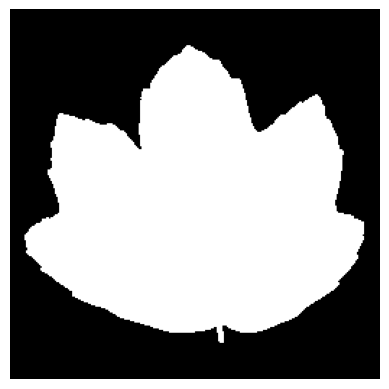

In [5]:
# Show first image
print(images.shape)
plt.imshow(images[0], cmap='gray')
plt.axis('off')
plt.show()

(594, 256, 256)


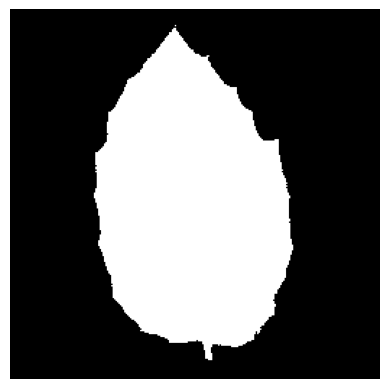

In [6]:
# Seperates test images and shows first image
test_id = test["id"].to_numpy(dtype=int)-1
X_comp = images[test_id]
print(X_comp.shape)

plt.imshow(X_comp[0], cmap='gray')
plt.axis('off')
plt.show()

(990, 256, 256)


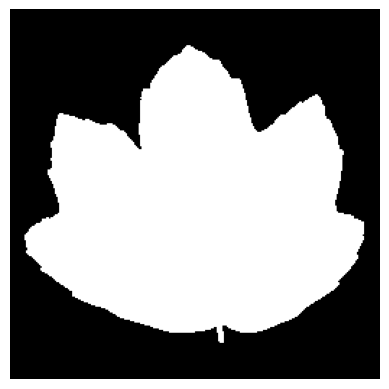

In [7]:
# Seperates training images and shows first image
train_id = train["id"].to_numpy(dtype=int)-1
X = images[train_id]
print(X.shape)

plt.imshow(X[0], cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# Convert y to integers
# Creates encoder and converts strings to integers
le = LabelEncoder()
y = le.fit_transform(train.species)

# Make dict of labels (int->str)
labels = {i: label for i, label in enumerate(le.classes_)}
print(labels)

{0: 'Acer_Capillipes', 1: 'Acer_Circinatum', 2: 'Acer_Mono', 3: 'Acer_Opalus', 4: 'Acer_Palmatum', 5: 'Acer_Pictum', 6: 'Acer_Platanoids', 7: 'Acer_Rubrum', 8: 'Acer_Rufinerve', 9: 'Acer_Saccharinum', 10: 'Alnus_Cordata', 11: 'Alnus_Maximowiczii', 12: 'Alnus_Rubra', 13: 'Alnus_Sieboldiana', 14: 'Alnus_Viridis', 15: 'Arundinaria_Simonii', 16: 'Betula_Austrosinensis', 17: 'Betula_Pendula', 18: 'Callicarpa_Bodinieri', 19: 'Castanea_Sativa', 20: 'Celtis_Koraiensis', 21: 'Cercis_Siliquastrum', 22: 'Cornus_Chinensis', 23: 'Cornus_Controversa', 24: 'Cornus_Macrophylla', 25: 'Cotinus_Coggygria', 26: 'Crataegus_Monogyna', 27: 'Cytisus_Battandieri', 28: 'Eucalyptus_Glaucescens', 29: 'Eucalyptus_Neglecta', 30: 'Eucalyptus_Urnigera', 31: 'Fagus_Sylvatica', 32: 'Ginkgo_Biloba', 33: 'Ilex_Aquifolium', 34: 'Ilex_Cornuta', 35: 'Liquidambar_Styraciflua', 36: 'Liriodendron_Tulipifera', 37: 'Lithocarpus_Cleistocarpus', 38: 'Lithocarpus_Edulis', 39: 'Magnolia_Heptapeta', 40: 'Magnolia_Salicifolia', 41: 'M

In [9]:
# Split X to training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=1, stratify=y_val)

In [10]:
# Check if all classes are represented
pd.Series(y_val).value_counts()

86    1
80    1
90    1
46    1
0     1
     ..
3     1
85    1
38    1
82    1
43    1
Name: count, Length: 99, dtype: int64

# Training

In [11]:
# # Best CNNs pipeline

# def multi_scale_block(x, filters=32):
#     # small pattern branch
#     b1 = Conv2D(filters, (1,1), padding='same')(x)
#     b1 = Activation('relu')(b1)
    
#     # medium pattern branch
#     b2 = Conv2D(filters, (3,3), padding='same')(x)
#     b2 = Activation('relu')(b2)

#     # larger context branch
#     b3 = Conv2D(filters, (12,12), padding='same')(x)
#     b3 = Activation('relu')(b3)

#     # merge all
#     return concatenate([b2, b3])

# inp = Input(shape=(256,256,1))

# x = multi_scale_block(inp, 16)
# x = MaxPooling2D((2,2))(x)

# x = multi_scale_block(x, 32)
# x = MaxPooling2D((2,2))(x)

# x = multi_scale_block(x, 64)
# x = MaxPooling2D((3,3))(x)

# x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
# x = MaxPooling2D((4,4))(x)

# x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)

# out = Dense(99, activation='softmax')(x)

# model = Model(inputs=inp, outputs=out)

# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"]
# )

# model.summary()

In [12]:
# Define model
def multi_scale_block(x, filters=32):
    # small pattern branch
    b1 = Conv2D(filters, (3,3), padding='same')(x)
    b1 = Activation('relu')(b1)
    
    # medium pattern branch
    b2 = Conv2D(filters, (5,5), padding='same')(x)
    b2 = Activation('relu')(b2)

    # larger context branch
    b3 = Conv2D(filters, (12,12), padding='same')(x)
    b3 = Activation('relu')(b3)

    # merge all
    return concatenate([b1, b2, b3])

inp = Input(shape=(256,256,1))

x = multi_scale_block(inp, 16)
x = MaxPooling2D((2,2))(x)

x = multi_scale_block(x, 32)
x = MaxPooling2D((2,2))(x)

x = multi_scale_block(x, 64)
x = MaxPooling2D((3,3))(x)

x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = MaxPooling2D((4,4))(x)

x = Flatten()(x)
x = Dense(150, activation='relu')(x)
x = Dropout(0.5)(x)

out = Dense(99, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)

model.compile( optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  416         ['input_1[0][0]']                
                                )                                                             

In [13]:
# Training model

history = model.fit(X_train, y_train, batch_size=16, epochs=40, validation_data=(X_val,y_val))

Epoch 1/40
50/50 [==============================] - 10s 96ms/step - loss: 16.0504 - accuracy: 0.0189 - val_loss: 4.4977 - val_accuracy: 0.0505
Epoch 2/40
50/50 [==============================] - 3s 61ms/step - loss: 4.4837 - accuracy: 0.0404 - val_loss: 4.1653 - val_accuracy: 0.0808
Epoch 3/40
50/50 [==============================] - 3s 61ms/step - loss: 4.0915 - accuracy: 0.0758 - val_loss: 3.5680 - val_accuracy: 0.2020
Epoch 4/40
50/50 [==============================] - 3s 61ms/step - loss: 3.6013 - accuracy: 0.1237 - val_loss: 2.9102 - val_accuracy: 0.2929
Epoch 5/40
50/50 [==============================] - 3s 61ms/step - loss: 3.1574 - accuracy: 0.1982 - val_loss: 2.3916 - val_accuracy: 0.4141
Epoch 6/40
50/50 [==============================] - 3s 61ms/step - loss: 2.6971 - accuracy: 0.2803 - val_loss: 2.1399 - val_accuracy: 0.5051
Epoch 7/40
50/50 [==============================] - 3s 61ms/step - loss: 2.4465 - accuracy: 0.3321 - val_loss: 1.8563 - val_accuracy: 0.4646
Epoch 8/40


Text(0.5, 1.0, 'Accuracy')

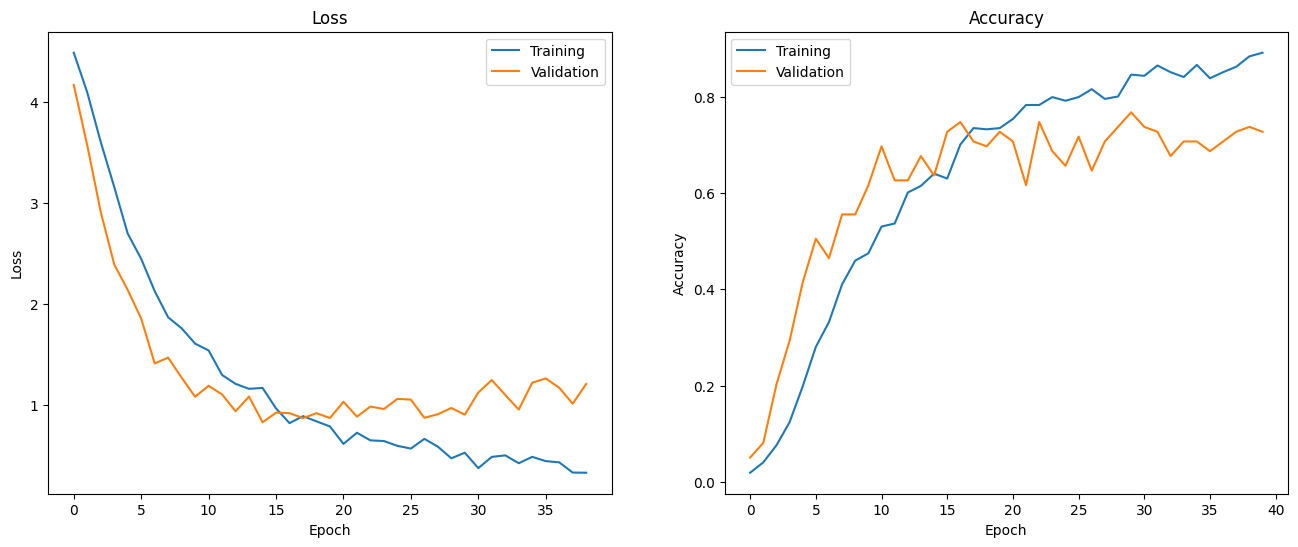

In [14]:
# Visualise the training and validation accuracy and loss dynamics over epochs
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.title('Accuracy')

4/4 [==============================] - 1s 18ms/step
Number of wrong predictions: 23
Accuracy: 0.7676767676767677


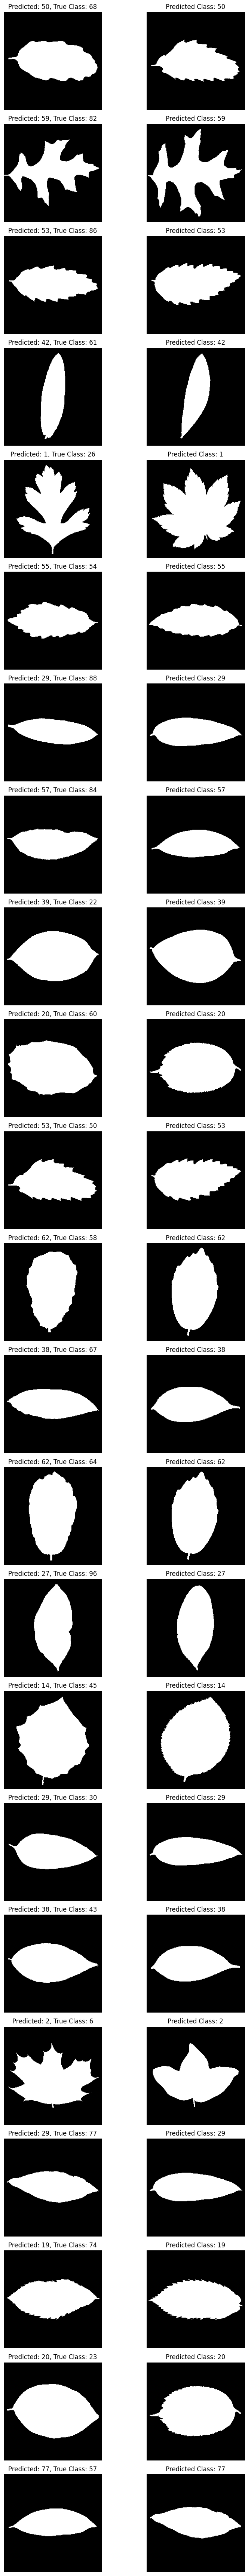

In [15]:
# Show misclassified samples
# Predict
pred_probs = model.predict(X_test)
pred_labels = np.argmax(pred_probs, axis=1)

# Find misclassified samples
wrong_idx = np.where(pred_labels != y_test)[0]

print("Number of wrong predictions:", len(wrong_idx))
print("Accuracy:", 1-len(wrong_idx)/len(X_test))

# Plot some wrong predictions
num_show = len(wrong_idx)

plt.figure(figsize=(12, num_show * 3))

for i, idx in enumerate(wrong_idx[:num_show]):
    img = X_test[idx].squeeze()
    true_label = y_test[idx]
    pred_label = pred_labels[idx]

    # Wrong classes
    plt.subplot(num_show, 3, 3*i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {pred_label}, True Class: {true_label}", color="black")
    plt.axis("off")

    # Find images from the predicted class
    pred_class_idx = np.where(y_test == pred_label)[0]
    correct_img = X_test[pred_class_idx].squeeze()

    plt.subplot(num_show, 3, 3*i + 2)
    plt.imshow(correct_img, cmap='gray')
    plt.title(f"Predicted Class: {pred_label}", color="black")
    plt.axis("off")

    # plt.subplot(num_show, 3, 3*i + 3)
    # plt.imshow(correct_img[1], cmap='gray')
    # plt.title(f"Predicted Class: {pred_label}", color="black")
    # plt.axis("off")

plt.tight_layout()
plt.show()

# Competition

In [16]:
sample_submission

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
1,7,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
2,9,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
3,12,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
4,13,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
590,1577,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
591,1579,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
592,1580,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101


In [17]:
# Get predictions
pred_probs = model.predict(X_comp)

19/19 [==============================] - 1s 54ms/step


In [18]:
# Make submission df
submission = pd.DataFrame(pred_probs, columns=le.classes_)
submission.insert(0, 'id', (test_id+1))

In [19]:
submission

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,5.103542e-07,2.873642e-04,6.836833e-09,1.281184e-09,1.759482e-03,3.605271e-07,9.688501e-10,1.252501e-06,2.496040e-06,...,1.895888e-10,2.638477e-07,1.113198e-03,4.485518e-09,2.423579e-06,4.620513e-09,3.034585e-05,6.449643e-05,9.799738e-13,1.762956e-08
1,7,4.593748e-10,1.665126e-14,3.853591e-12,1.767718e-20,1.772462e-15,4.917451e-14,1.341364e-15,9.997171e-12,1.516691e-16,...,4.380618e-14,2.878161e-10,2.054827e-14,8.644089e-17,6.449813e-11,3.976755e-18,4.033955e-09,3.460314e-18,6.585683e-12,1.435739e-06
2,9,1.319779e-18,1.000000e+00,2.227904e-12,3.005527e-14,4.261020e-15,7.603868e-28,5.075097e-08,1.712560e-10,1.974510e-16,...,3.422699e-32,9.389521e-21,1.187316e-16,1.432900e-20,6.091441e-15,1.229414e-18,2.727075e-18,2.117986e-22,4.894226e-27,3.925384e-26
3,12,1.722987e-19,2.598265e-21,3.728990e-14,4.667860e-22,7.339673e-17,3.083830e-23,3.296229e-19,1.106687e-13,1.397888e-15,...,4.184235e-18,1.297504e-22,1.504441e-16,4.021818e-20,2.420837e-18,1.743852e-23,1.409198e-27,1.527409e-17,3.737953e-27,9.724177e-20
4,13,8.429456e-10,3.953398e-11,2.181192e-08,2.150300e-10,6.308313e-07,2.515671e-07,1.218766e-07,1.069177e-08,1.851513e-08,...,7.919033e-09,3.353318e-07,3.189532e-02,1.794780e-05,1.172113e-05,3.231352e-06,7.299224e-09,5.912062e-07,2.048637e-09,3.465113e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,1.520160e-22,1.000000e+00,1.399512e-16,1.322570e-19,1.316236e-15,4.007000e-29,7.635992e-12,1.664472e-12,1.240683e-19,...,4.256927e-37,2.641618e-26,6.296097e-18,1.054173e-24,4.642046e-17,1.344082e-23,1.080627e-22,2.544686e-27,1.892404e-30,4.654057e-29
590,1577,1.502450e-09,2.019829e-05,9.142760e-07,4.532590e-09,3.028822e-05,6.204318e-08,7.889366e-07,4.294148e-06,6.844405e-07,...,1.161890e-11,3.411134e-06,1.528648e-03,3.702041e-08,2.977991e-07,1.304897e-07,3.069558e-07,1.543662e-07,5.100791e-11,3.963800e-09
591,1579,2.544958e-08,5.796447e-13,1.124139e-08,9.230167e-11,3.563433e-13,4.495514e-16,4.234584e-11,7.450036e-11,7.574146e-14,...,1.657567e-13,1.150078e-08,6.076015e-13,5.492042e-12,2.626395e-08,4.326381e-11,1.524855e-09,2.113525e-16,5.910209e-05,2.686629e-07
592,1580,2.801898e-13,4.152930e-08,9.849099e-11,2.246515e-09,1.496906e-10,9.245600e-14,1.882076e-07,9.727398e-10,1.390088e-09,...,1.541376e-12,8.006487e-17,1.524477e-03,8.782625e-14,1.113937e-11,7.308007e-09,3.681111e-15,7.644748e-04,3.932978e-13,9.073893e-16


In [20]:
# Check if all row sum up to 1
submission[le.classes_].sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
589    1.0
590    1.0
591    1.0
592    1.0
593    1.0
Length: 594, dtype: float32

In [21]:
# Save df
submission.to_csv('submission.csv', index=False)

In [22]:
# Export model
model.save("CNN_leaf")

INFO:tensorflow:Assets written to: CNN_leaf\assets


INFO:tensorflow:Assets written to: CNN_leaf\assets


In [23]:
# Import model
from tensorflow import keras
model2 = keras.models.load_model("CNN_leaf")